# PV Diagnosis

In case of large-scale renewable energy plants, production output is regularly reviewed to ensure ROI. This is different for small plants. By comparing predicted production based on past meteorological data with actual production of a PV power plant, we estimate plant's condition and predict next required maintenance. The analysis detects performance losses and, therby, enhances economic profits. This challenge was part of the Energy Hackdays 2019 (https://hack.opendata.ch/project/284).


## Model

$q_{t,p} = \alpha_0 + \alpha_1 \times \hat{q}_{t,p}(\omega_{t-1}) + \epsilon_{t,p}$,
where $q_{t,p}$ is actual production, $\hat{q}_{t,p}$ estimated potential production based on past weather parameters $\omega_{t-1}$. 

## Approach
1. Estimate potential production based on past weather parameters $\hat{q}_{t,p}(\omega_{t-1})$
2. Compare this estimation with actual production $q_{t,p}$


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import ppscore as pps
import sys,os

In [20]:
os.chdir("..")
sys.path.append(os.getcwd())
from preprocessor.paths import (PATH_TO_PLANT_A,
                                 PATH_TO_PLANT_B,
                                 PATH_TO_PLANT_C,
                                 PATH_TO_WEATHER)
from preprocessor.preprocessor import Preprocessor

In [1]:
data_plant_a = Preprocessor(PATH_TO_PLANT_A, "timestamp").df_indexed_utc
data_weather = Preprocessor(PATH_TO_WEATHER, "local_time").df_indexed_utc

NameError: name 'Preprocessor' is not defined

## Weather (Radiation) Prediction

### Which factors contribute most to PV production?

In [4]:
data = pd.merge(left=data_plant_a, right=data_weather,
                left_index=True, right_index=True)
data.columns

Index(['generation_kw', 'grid_feedin_kw', 'grid_supply_kw',
       'overall_consumption_calc_kw', 'temperature', 'precipitation',
       'snowfall', 'snow_mass', 'air_density', 'radiation_surface',
       'radiation_toa', 'cloud_cover'],
      dtype='object')

In [5]:
data_plant_a.head()

,generation_kw,grid_feedin_kw,grid_supply_kw,overall_consumption_calc_kw
timestamp_utc,,,,
2018-12-31 23:00:00+00:00,0.0,0.0,4.214,4.214
2019-01-01 00:00:00+00:00,0.0,0.0,4.212,4.212
2019-01-01 01:00:00+00:00,0.0,0.0,4.364,4.364
2019-01-01 02:00:00+00:00,0.0,0.0,4.214,4.214
2019-01-01 03:00:00+00:00,0.0,0.0,4.364,4.364


In [6]:
data_weather.head()

,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover
timestamp_utc,,,,,,,,
2019-01-01 00:00:00+00:00,-2.542,0.001,0.0,10.513,1.106,0.0,0.0,0.001
2019-01-01 01:00:00+00:00,-2.190,0.001,0.0,10.515,1.106,0.0,0.0,0.043
2019-01-01 02:00:00+00:00,-2.182,0.001,0.0,10.516,1.106,0.0,0.0,0.171
2019-01-01 03:00:00+00:00,-2.230,0.000,0.0,10.517,1.106,0.0,0.0,0.379
2019-01-01 04:00:00+00:00,-2.113,0.000,0.0,10.517,1.105,0.0,0.0,0.558


In [7]:
def heatmap(df):
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", 
                          linewidths=0.5, annot=True, ax=ax)
    heatmap.set_title('PPS matrix')
    heatmap.set_xlabel('feature')
    heatmap.set_ylabel('target')
    return heatmap

In [8]:
def corr_heatmap(df):
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

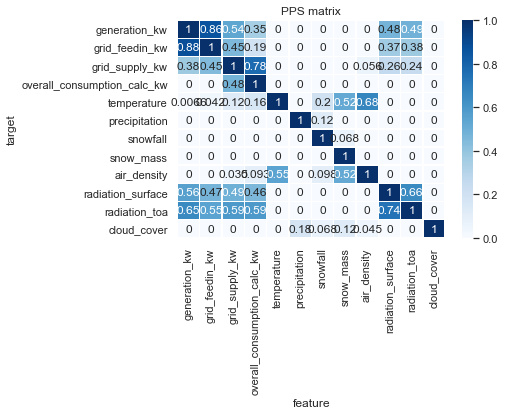

In [9]:
sns.set()
heatmap(pps.matrix(data))

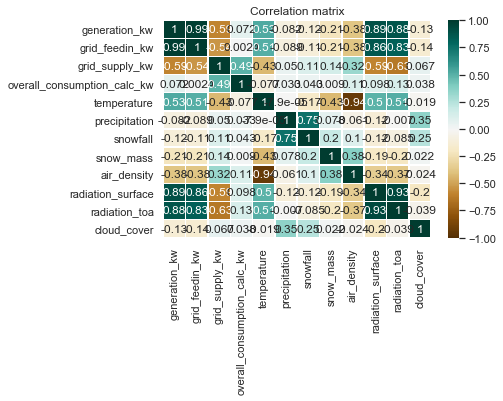

In [10]:
corr_heatmap(data.corr())

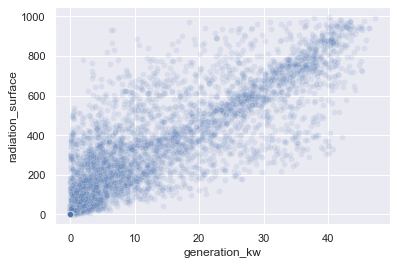

In [11]:
sns.scatterplot(data=data, x="generation_kw", y="radiation_surface", alpha=0.1)

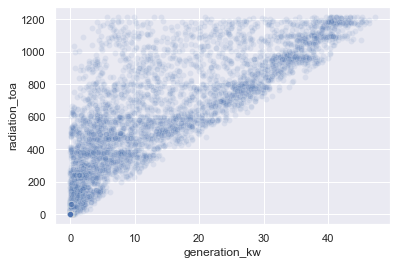

In [12]:
sns.scatterplot(data=data, x="generation_kw", y="radiation_toa", alpha=0.1)

### Predict radiation in top of athmosphere based on past weather factors

#### Linear Regression

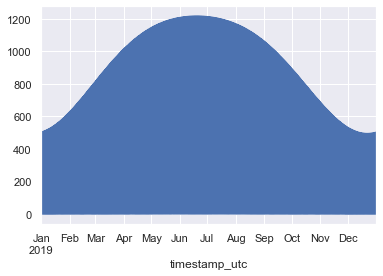

In [13]:
data["radiation_toa"].plot()

generation_kw


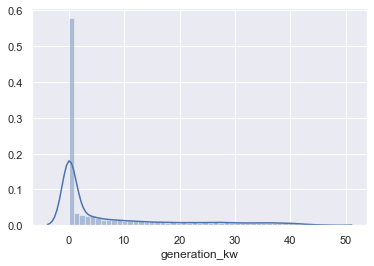

grid_feedin_kw


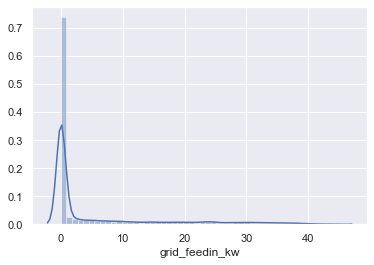

grid_supply_kw


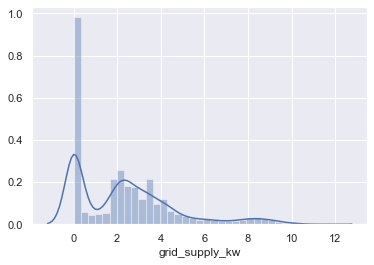

overall_consumption_calc_kw


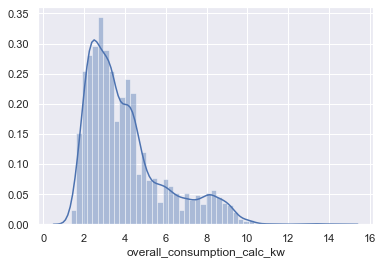

temperature


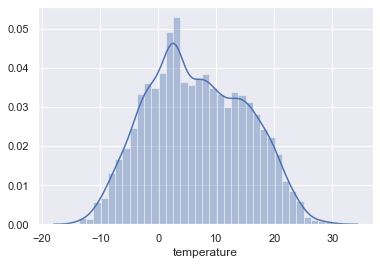

precipitation


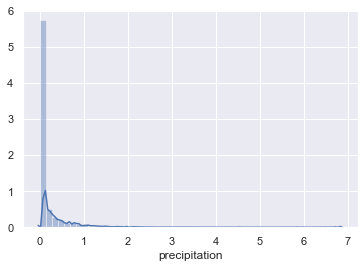

snowfall


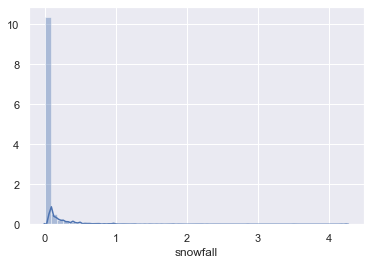

snow_mass


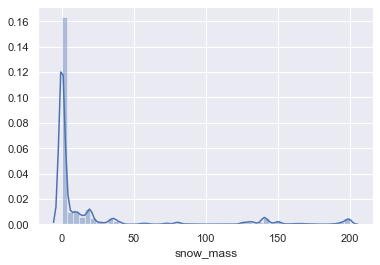

air_density


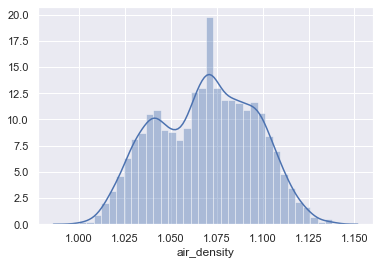

radiation_surface


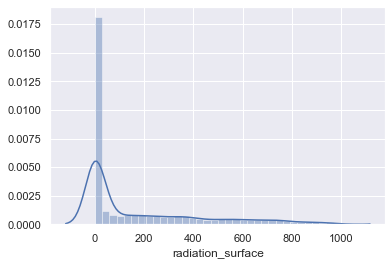

radiation_toa


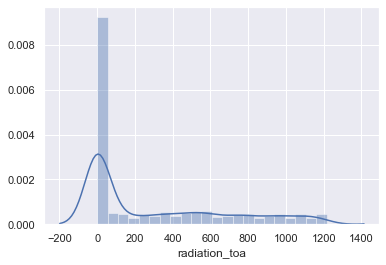

cloud_cover


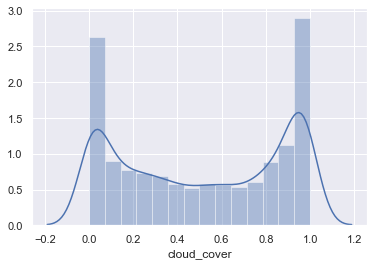

In [14]:
for col in data.columns:
    print(col)
    sns.distplot(data[col])
    plt.show()

In [15]:
data.columns

Index(['generation_kw', 'grid_feedin_kw', 'grid_supply_kw',
       'overall_consumption_calc_kw', 'temperature', 'precipitation',
       'snowfall', 'snow_mass', 'air_density', 'radiation_surface',
       'radiation_toa', 'cloud_cover'],
      dtype='object')

In [16]:
# separate our my predictor variables (X) from my outcome variable y
predictors = ['temperature', 'precipitation', 'snowfall', 'snow_mass', 'air_density', 
              'radiation_surface', 'cloud_cover']
X = data[predictors]
y = data['radiation_toa']

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X

,const,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,cloud_cover
timestamp_utc,,,,,,,,
2019-01-01 00:00:00+00:00,1.0,-2.542,0.001,0.0,10.513,1.106,0.0,0.001
2019-01-01 01:00:00+00:00,1.0,-2.190,0.001,0.0,10.515,1.106,0.0,0.043
2019-01-01 02:00:00+00:00,1.0,-2.182,0.001,0.0,10.516,1.106,0.0,0.171
2019-01-01 03:00:00+00:00,1.0,-2.230,0.000,0.0,10.517,1.106,0.0,0.379
2019-01-01 04:00:00+00:00,1.0,-2.113,0.000,0.0,10.517,1.105,0.0,0.558
...,...,...,...,...,...,...,...,...
2019-12-31 18:00:00+00:00,1.0,-1.511,0.000,0.0,199.626,1.094,0.0,0.934
2019-12-31 19:00:00+00:00,1.0,-1.808,0.000,0.0,199.626,1.095,0.0,0.566
2019-12-31 20:00:00+00:00,1.0,-1.897,0.000,0.0,199.627,1.096,0.0,0.320


In [17]:
X[X.isna().sum(axis=1)>0]

,const,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,cloud_cover
timestamp_utc,,,,,,,,


In [ ]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          radiation_toa   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:45:32   Log-Likelihood:                -54292.
No. Observations:                8759   AIC:                         1.086e+05
Df Residuals:                    8751   BIC:                         1.087e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               248.5804    163.286      1.522      0.128     -71.499     568.660
temperature          -0.0432      0.529     -0.082      0.935      -1.081       0.994
precipitation       140.5826      5.321     26.421      0.000     130.152     151.013
snowfall           -227.3570     11.544    -19.694      0.000    -249.986    -204.728
snow_mass            -0.0368      0.029     -1.276      0.202      -0.093       0.020
air_density        -262.2673    150.054     -1.748      0.081    -556.408      31.873
radiation_surface     1.4519      0.007    223.167      0.000       1.439       1.465
cloud_cover         132.9167      3.782     35.142      0.000     125.502     140.331
==============================================================================
Omnibus:                     2592.249   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9933.996
Skew:                           1.436   Prob(JB):                         0.00
Kurtosis:                       7.356   Cond. No.                     5.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""